In [89]:
path="C:\\Users\\Adam\\Documents\\Python Scripts\\ClothesDataset\\images_compressed\\" #path to where original images are stored
path2="C:\\Users\\Adam\\Documents\\Python Scripts\\ClothesDataset\\ClassifiedImages\\" #path where images after processed are stored
path3="C:\\Users\\Adam\\Documents\\Python Scripts\\ClothesDataset\\testdata\\"
import pandas as pd

import matplotlib.pyplot as plt

In [90]:

ClothingData = pd.read_csv(r"C:\Users\Adam\Documents\Python Scripts\ClothesDataset\images.csv") #dataset csv path

In [91]:
classlabel = []
i=0
for item_name in ClothingData.label: 
   if item_name=="Not sure":
      classlabel.append(0)
      
   elif item_name=="T-Shirt":
      classlabel.append(1)

   elif item_name=="Shoes":
      classlabel.append(2)
      
   elif item_name=="Shorts":
      classlabel.append(3)      

   elif item_name=="Shirt":
      classlabel.append(4)
      
   elif item_name=="Pants":
      classlabel.append(5)  
   
   elif item_name=="Skirt":
      classlabel.append(6)
      
   elif item_name=="Top":
      classlabel.append(7)
   
   elif item_name=="Outwear":
      classlabel.append(8)
      
   elif item_name=="Dress":
      classlabel.append(9)
   
   elif item_name=="Body":
      classlabel.append(10)
      
   elif item_name=="Longsleeve":
      classlabel.append(11)

   elif item_name=="Undershirt":
      classlabel.append(12)
      
   elif item_name=="Hat":
      classlabel.append(13)      

   elif item_name=="Polo":
      classlabel.append(14)
      
   elif item_name=="Blouse":
      classlabel.append(15)  
   
   elif item_name=="Hoodie":
      classlabel.append(16)
      
   elif item_name=="Skip":
      classlabel.append(17)
   
   elif item_name=="Blazer":
      classlabel.append(18)
   
   elif item_name=="Other":
      classlabel.append(19)
 
   

   

      

ClothingData['BinaryClassification'] = classlabel

ClothingData

,image,sender_id,label,kids,BinaryClassification
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False,0
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,1
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False,0
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,1
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,2
...,...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False,3
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True,10
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False,3
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False,2


In [92]:

import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import numpy as np

import pathlib

data_dir = path2
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#split data to train and test

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

407
Found 407 files belonging to 4 classes.
Using 326 files for training.
Found 407 files belonging to 4 classes.
Using 81 files for validation.
['Blazer', 'Hoodie', 'Skirt', 'Top']


In [93]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch2 in val_ds:
  print(image_batch.shape)
  print(labels_batch2.shape)
  break


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
0.011437222 0.9764053


In [94]:
from keras import backend as K
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#model.compile(optimizer='adam',
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 #            metrics=['accuracy'])

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
  
def truepositive(y_true, y_pred):
  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    return true_positives


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='Adam', metrics=['accuracy', precision, recall,truepositive])

#model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy', tf.keras.metrics.SensitivityAtSpecificity(0.5)])

#view model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [95]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 4s 316ms/step - loss: 1.7057 - accuracy: 0.3466 - precision: 30909090.0000 - recall: 1.0148 - truepositive: 23.6364 - val_loss: 1.3239 - val_accuracy: 0.3704 - val_precision: 1.2805 - val_recall: 1.0933 - val_truepositive: 20.3333
Epoch 2/10
11/11 [==============================] - 3s 246ms/step - loss: 1.2686 - accuracy: 0.4172 - precision: 1.5771 - recall: 1.2277 - truepositive: 27.3636 - val_loss: 1.3061 - val_accuracy: 0.3704 - val_precision: 0.9659 - val_recall: 1.1885 - val_truepositive: 22.6667
Epoch 3/10
11/11 [==============================] - 3s 229ms/step - loss: 1.1370 - accuracy: 0.5184 - precision: 0.9882 - recall: 1.2650 - truepositive: 28.0000 - val_loss: 1.1977 - val_accuracy: 0.4444 - val_precision: 0.8431 - val_recall: 1.5714 - val_truepositive: 29.6667
Epoch 4/10
11/11 [==============================] - 2s 227ms/step - loss: 0.9442 - accuracy: 0.6350 - precision: 0.9026 - recall: 1.4437 - truepositive: 31.3636 - va

In [96]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


In [97]:

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [98]:
recall = history.history['recall']
val_recall = history.history['val_recall']
print("Recall Value:")
print(recall)
print(val_recall)

precision = history.history['precision']
val_precision = history.history['val_precision']
print("Precision Value")
print(precision)
print(val_precision)


tp = history.history['truepositive']
val_tp = history.history['val_truepositive']
print("True Positive Value: ")
print(tp)
print(val_tp)

Recall Value:
[1.0148138999938965, 1.227749228477478, 1.2650099992752075, 1.4437211751937866, 1.549076795578003, 1.8223553895950317, 2.072392702102661, 1.952966570854187, 1.9278193712234497, 1.8562337160110474]
[1.0932539701461792, 1.188491940498352, 1.5714284181594849, 1.480158805847168, 1.7916666269302368, 2.2281744480133057, 2.4742062091827393, 2.1706349849700928, 2.0257937908172607, 2.1607143878936768]
Precision Value
[30909090.0, 1.577088475227356, 0.988193154335022, 0.9026346206665039, 0.7943332195281982, 0.7712998986244202, 0.7513074278831482, 0.7486705780029297, 0.7583248615264893, 0.7398224472999573]
[1.2805218696594238, 0.965867817401886, 0.8430877327919006, 0.8243746161460876, 0.6891581416130066, 0.7782285213470459, 0.7811636328697205, 0.7422016263008118, 0.7331745028495789, 0.7378066182136536]
True Positive Value: 
[23.636363983154297, 27.363636016845703, 28.0, 31.363636016845703, 33.6363639831543, 40.181819915771484, 45.727272033691406, 42.727272033691406, 42.1818199157714

In [99]:
img = tf.keras.utils.load_img(
    path3+'Hoodie//2c74a33c-4267-4bd0-946c-0dd214183f5b.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)  
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 95ms/step
This image most likely belongs to Hoodie with a 99.78 percent confidence.


In [100]:
from operator import index
import tensorflow as tf
import glob
import cv2
import os
from PIL import Image

data_dir = path3
#data_dir = pathlib.Path(data_dir)

image_data = []
label_data=[]

# iterate over files in
# that directory
for images in glob.iglob(f'{data_dir}/*'):
    #image = cv2.imread (images)
    
    #img = tf.keras.utils.load_img(images)
    img_array = tf.keras.utils.img_to_array(img)
    img_array=img_array/255
    image_data.append (img_array)
    i=0
   # for c in ClothingData.index: 
    #    if os.path.basename(images)==(ClothingData["image"].iloc[c]+".jpg"):
    #            label_data.append(ClothingData["BinaryClassification"].iloc[c])
        
    # check if the image ends with png
    





In [136]:
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    path3, # Put your path here
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   


x=np.concatenate([test_data_generator.next()[0] for i in range(test_data_generator.__len__())])
y=np.concatenate([test_data_generator.next()[1] for i in range(test_data_generator.__len__())])

pixels = x.flatten()
pixels = x.flatten().reshape(203, 97200)
print (pixels.shape)
print(true_classes.shape)
print(x.shape)


report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  



Found 203 images belonging to 4 classes.


C:\Users\Adam\AppData\Local\Temp\ipykernel_21936\1067396726.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)


(203, 97200)
(203,)
(203, 180, 180, 3)
              precision    recall  f1-score   support

      Blazer       0.93      0.93      0.93        55
      Hoodie       0.81      0.94      0.87        54
       Skirt       0.93      0.88      0.90        72
         Top       1.00      0.77      0.87        22

    accuracy                           0.90       203
   macro avg       0.92      0.88      0.89       203
weighted avg       0.90      0.90      0.90       203



In [102]:
confusion_matrix(true_classes, predicted_classes)



array([[51,  4,  0,  0],
       [ 1, 51,  2,  0],
       [ 3,  6, 63,  0],
       [ 0,  2,  3, 17]], dtype=int64)

In [103]:
from sklearn.metrics import plot_confusion_matrix

class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, class_names)


#figsize = (12,12)
#plot_confusion_matrix(estimator=classifier, X=normalizedtruth, y_true=normalizedpred, cmap='Blues', normalize='true', ax=plt.subplots(figsize=figsize)[1])



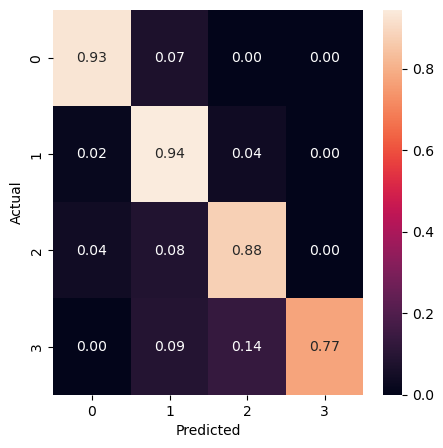

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=1, yticklabels=1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [105]:
# from sklearn.model_selection import KFold, StratifiedKFold
# import tensorflow as tf
# #from tensorflow.keras.preprocessing.image import ImageDataGenerator

# idg = ImageDataGenerator(width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
#                          rescale=1./255)

# def get_model_name(k):
#     return 'model_'+str(k)+'.h5'

# VALIDATION_ACCURACY = []
# VALIDAITON_LOSS = []


# Y = ClothingData[['BinaryClassification']]

# kf = KFold(n_splits = 5)
                         
# skf = StratifiedKFold(n_split = 5, random_state = 7, shuffle = True) 


# save_dir = '/saved_models/'
# fold_var = 1

# for train_index, val_index in kf.split(np.zeros(n),Y):
# 	training_data = ClothingData.iloc[train_index]
# 	validation_data = ClothingData.iloc[val_index]
	
# 	train_data_generator = idg.flow_from_dataframe(training_data, directory = path2,
# 						       x_col = "filename", y_col = "label",
# 						       class_mode = "categorical", shuffle = True)
# 	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = path2,
# 							x_col = "filename", y_col = "label",
# 							class_mode = "categorical", shuffle = True)
	
# 	# CREATE NEW MODEL
# 	model = create_new_model()
# 	# COMPILE NEW MODEL
# 	model.compile(loss='categorical_crossentropy',
# 		      optimizer=opt,
# 		      metrics=['accuracy'])
	
# 	# CREATE CALLBACKS
# 	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
# 							monitor='val_accuracy', verbose=1, 
# 							save_best_only=True, mode='max')
# 	callbacks_list = [checkpoint]
# 	# There can be other callbacks, but just showing one because it involves the model name
# 	# This saves the best model
# 	# FIT THE MODEL
# 	history = model.fit(train_data_generator,
# 			    epochs=num_epochs,
# 			    callbacks=callbacks_list,
# 			    validation_data=valid_data_generator)
# 	#PLOT HISTORY
# 	#		:
# 	#		:
	
# 	# LOAD BEST MODEL to evaluate the performance of the model
# 	model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
	
# 	results = model.evaluate(valid_data_generator)
# 	results = dict(zip(model.metrics_names,results))
	
# 	VALIDATION_ACCURACY.append(results['accuracy'])
# 	VALIDATION_LOSS.append(results['loss'])
	
# 	tf.keras.backend.clear_session()
	
# 	fold_var += 1

In [106]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(y_train)

[0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0
 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2
 0]


In [143]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(pixels, true_classes, test_size=0.5, random_state=0)
print(X_train)
gnb = GaussianNB()

Gaussian_Pred = gnb.fit(X_train, y_train).predict(X_test)

print(Gaussian_Pred)



print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != Gaussian_Pred).sum()))
test=(y_test != Gaussian_Pred).sum()
accuracy=(test/X_test.shape[0])*100
print(accuracy)
report = classification_report(y_test, Gaussian_Pred, target_names=class_labels)
print(report)  

[[ 47.  47.  47. ...  80.  80.  80.]
 [ 98.  98.  98. ...  88.  88.  88.]
 [151. 151. 151. ...  92.  92.  92.]
 ...
 [211. 211. 211. ... 135. 135. 135.]
 [205. 205. 205. ... 208. 208. 208.]
 [ 53.  53.  53. ...  36.  36.  36.]]
[2 0 0 2 2 1 0 2 2 0 1 0 1 3 1 3 0 0 3 3 1 3 1 3 2 1 1 2 0 1 2 0 2 3 0 2 0
 1 1 3 3 0 1 1 0 1 0 0 0 0 3 0 3 0 0 1 0 0 2 1 2 1 3 1 0 3 1 0 0 0 3 3 2 1
 1 2 2 2 0 0 3 2 0 0 0 2 2 1 0 3 3 3 0 0 0 0 3 0 0 1 0 2]
Number of mislabeled points out of a total 102 points : 63
61.76470588235294
              precision    recall  f1-score   support

      Blazer       0.41      0.62      0.49        26
      Hoodie       0.52      0.44      0.48        27
       Skirt       0.35      0.18      0.24        38
         Top       0.20      0.36      0.26        11

    accuracy                           0.38       102
   macro avg       0.37      0.40      0.37       102
weighted avg       0.39      0.38      0.37       102

